In [1]:
import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv
import os, sys
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
%cd /home/jovyan/ASMSA/mydev


repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

from src.utils import plot_latent_space
from src.asmsa_callbacks import callbacks
from src.ae import asmsa_ae
from src.asmsa_features import process_trajectory
from src.asmsa_split import asmsa_datasets
from src.asmsa_analysis import analyze_reconstruction_with_sincos_blocks, plot_section_errors
from src.asmsa_loss import asmsa_ae_loss

nn_model = 'ae'
latent_dim = 2

2025-08-28 15:36:41.607882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-28 15:36:41.622905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-28 15:36:41.627162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-28 15:36:41.636781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-28 15:36:42.328706: W tensorflow/compiler/tf2

[Errno 2] No such file or directory: '/home/jovyan/ASMSA/mydev'
/home/tedeschg/prj/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)


<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x730059ee9fc0>

In [3]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
pdb_path = conf

backbone = []
with open(pdb_path) as f:
    atom_counter = 0
    for line in f:
        if not line.startswith("ATOM"):
            continue
        name = line[12:16].strip()
        if name == "N" or name == "C" or name=="CA":
            backbone.append(atom_counter)
        atom_counter += 1

ON = []
with open(pdb_path) as f:
    atom_counter = 0
    for line in f:
        if not line.startswith("ATOM"):
            continue
        name = line[12:16].strip()
        if name == "N" or name == "O":
            ON.append(atom_counter)
        atom_counter += 1

polar = []
with open(pdb_path) as f:
    atom_counter = 0
    for line in f:
        if not line.startswith("ATOM"):
            continue
        name = line[12:16].strip()
        pol = {
            "N", #backbone amide nitrogen
            "O", #backbone carbonyl oxygen
            "OG", #Serine
            "OG1", #Threonine
            "OH2", #Tyrosine
            "SG", #Cysteine
            "OD1", #Aspartate
            "OD2", #Aspartate
            "OE1", #Glutamate
            "OE2", #Glutamate 
            "ND2", #Asparagine
            "OD1", #Asparagine
            "NE2", #Glutamine
            "OE1", #Glutamine
            "ND1", #Histidine
            "NE2", #Histidine
            "NZ", #Lysine
            "NE", #Arginine
            "NH1", #Arginine
            "NH2", #Arginine
        }
        if name in pol:
            polar.append(atom_counter)
        atom_counter += 1

            
alpha = []
with open(pdb_path) as f:
    atom_counter = 0
    for line in f:
        if not line.startswith("ATOM"):
            continue
        name = line[12:16].strip()
        if name == "CA":
            alpha.append(atom_counter)
        atom_counter += 1

alphabeta = []
with open(pdb_path) as f:
    atom_counter = 0
    for line in f:
        if not line.startswith("ATOM"):
            continue
        name = line[12:16].strip()
        if name == "CA" or name == "CB":
            alphabeta.append(atom_counter)
        atom_counter += 1

print(f'Backbone({len(backbone)}): {backbone}')
print(f'ON({len(ON)}): {ON}')
print(f'Polar Atoms ({len(polar)}): {polar}')
print(f'Alpha C ({len(alpha)}): {alpha}')
print(f'Alpha and Beta ({len(alphabeta)}): {alphabeta}')

bonds = np.array([[backbone[i], backbone[i+1]] for i in range(len(backbone) - 1)])
angles = np.array([[backbone[i], backbone[i+1], backbone[i+2]] for i in range(len(backbone) - 2)])
dih = np.array([backbone[i:i+4] for i in range(len(backbone) - 3)])

Backbone(60): [0, 1, 6, 8, 9, 11, 13, 14, 23, 25, 26, 28, 30, 31, 37, 39, 40, 51, 53, 54, 59, 61, 62, 64, 66, 67, 72, 74, 75, 76, 78, 79, 80, 82, 86, 87, 89, 90, 93, 95, 96, 99, 101, 102, 103, 105, 106, 114, 116, 120, 121, 123, 127, 128, 130, 134, 135, 137, 138, 141]
ON(39): [0, 7, 8, 12, 13, 24, 25, 29, 30, 38, 39, 52, 53, 60, 61, 65, 66, 73, 74, 77, 78, 81, 82, 88, 89, 94, 95, 100, 101, 104, 105, 115, 116, 122, 123, 129, 130, 136, 137]
Polar Atoms (51): [0, 4, 5, 7, 8, 12, 13, 24, 25, 29, 30, 35, 36, 38, 39, 52, 53, 60, 61, 65, 66, 70, 71, 73, 74, 77, 78, 81, 82, 88, 89, 92, 94, 95, 98, 100, 101, 104, 105, 110, 112, 113, 115, 116, 122, 123, 129, 130, 136, 137, 140]
Alpha C (20): [1, 9, 14, 26, 31, 40, 54, 62, 67, 75, 79, 86, 90, 96, 102, 106, 120, 127, 134, 138]
Alpha and Beta (37): [1, 2, 9, 10, 14, 15, 26, 27, 31, 32, 40, 41, 54, 55, 62, 63, 67, 68, 75, 79, 85, 86, 90, 91, 96, 97, 102, 106, 107, 119, 120, 126, 127, 133, 134, 138, 139]


In [5]:
feat = process_trajectory(
    traj=tr,
    conf=conf,
    atom_selection=alpha,      # 'protein' | 'backbone' | 'CA' | lista indici
    distance_mode="dense",   # 'sparse' o 'dense'
    density=2,                # only if sparse; 1..N
    include_angles=True
)

In [6]:
print(f"feature_keys: {feat.keys()}, feat_distances_shape: {(feat['dists'].shape)}")

feature_keys: dict_keys(['ca_indices', 'n_ca', 'bb_indices', 'n_bb', 'p_indices', 'n_p', 'atom_indices_used', 'distance_pairs', 'n_pairs', 'dists', 'scaler_dists', 'n_distance_features', 'raw_angles', 'scaler_angles', 'n_angle_features', 'features_normalized']), feat_distances_shape: (50001, 190)


## NN preprocessing

In [7]:
# Uso:
ds_train, ds_val, ds_test, ds_all, info = asmsa_datasets(feat['features_normalized'], train_size=70, val_size=15, batch_size=64, seed=42)

I0000 00:00:1756388207.522356   65203 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756388207.540507   65203 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756388207.540681   65203 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1756388207.541606   65203 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset Split Statistics:
  Total samples: 50001
  Train: 35000 samples (70.0%), 546 batches
  Val:   7500 samples (15.0%), 118 batches
  Test:  7501 samples (15.0%), 118 batches
  Batch size: 64
  Features shape: (50001, 266)
  Seed: 42

Validazione splits:


2025-08-28 15:36:48.825708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-08-28 15:36:48.937768: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


  Train batch shape: (64, 266)
  Val batch shape: (64, 266)
  Test batch shape: (64, 266)
  ✓ Tutti gli split sono validi per autoencoder


2025-08-28 15:36:49.078418: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# AE

In [8]:
autoencoder, encoder, decoder = asmsa_ae(
    n_features=feat['features_normalized'].shape[1],
    latent_dim=latent_dim)

autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_input (InputLayer)          │ (None, 266)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        44,578 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 266)            │        44,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,420 (349.30 KB)

 Trainable params: 89,420 (349.30 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
nD = feat['n_distance_features']
nA = feat['n_angle_features']

dist_slice = slice(0, nD)
ang_slice  = slice(nD, nD + nA)


## Train

In [10]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cb = callbacks(log_dir, latent_dim, monitor="val_loss", model=nn_model)  

learning_rate = 1e-4
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=1e-5, 
    beta_1=0.9,
    beta_2=0.999
)

# Assuming asmsa_ae function exists
ae, encoder, decoder = asmsa_ae(
    n_features=feat['features_normalized'].shape[1],
    latent_dim=latent_dim
)
# Compilo l'autoencoder con la loss personalizzata
ae.compile(optimizer=optimizer,
           loss=asmsa_ae_loss(nD,nA),
           )


tensorboard --logdir logs/autoencoder --host localhost --port 6006

In [11]:
ae.fit(ds_train,epochs=500,validation_data=ds_val,callbacks=cb)

Epoch 1/500


I0000 00:00:1756388212.484481   65261 service.cc:146] XLA service 0x72ff60003a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756388212.484500   65261 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-28 15:36:52.536623: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-28 15:36:52.785693: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 60/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0796 

I0000 00:00:1756388216.033154   65261 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


540/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0621
Epoch 1: val_loss improved from inf to 0.04302, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0620 - val_loss: 0.0430 - learning_rate: 1.0000e-04
Epoch 2/500
532/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0442
Epoch 2: val_loss improved from 0.04302 to 0.04185, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0442 - val_loss: 0.0419 - learning_rate: 1.0000e-04
Epoch 3/500
518/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0426
Epoch 3: val_loss improved from 0.04185 to 0.04044, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0426 - val_loss: 0.0404 - learning_rate: 1.0000e-04
Epoch 4/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0413
Epoch 4: val_loss improved from 0.04044 to 0.03994, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0413 - val_loss: 0.0399 - learning_rate: 1.0000e-04
Epoch 5/500


In [12]:
src = f"ae_{latent_dim}d.keras"
dest = "/home/tedeschg/prj/ASMSA/mydev/models/"

!mv {src} {dest}

# Decode and visualize

In [13]:
path = f"/home/tedeschg/prj/ASMSA/mydev/models/ae_{latent_dim}d.keras"

autoencoder = load_model(
    path,
    custom_objects={"recon_loss": asmsa_ae_loss(nD, nA)}
)

encoder = autoencoder.get_layer("encoder")
decoder = autoencoder.get_layer("decoder")


In [14]:
for batch_x, _ in ds_test.take(1):
    sample_x = batch_x[30]  
    break
    
sample_x_batch = tf.expand_dims(sample_x, axis=0)
test = encoder.predict(sample_x_batch)

test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


2025-08-28 15:39:48.500029: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([[10.340449,  4.803146]], dtype=float32)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


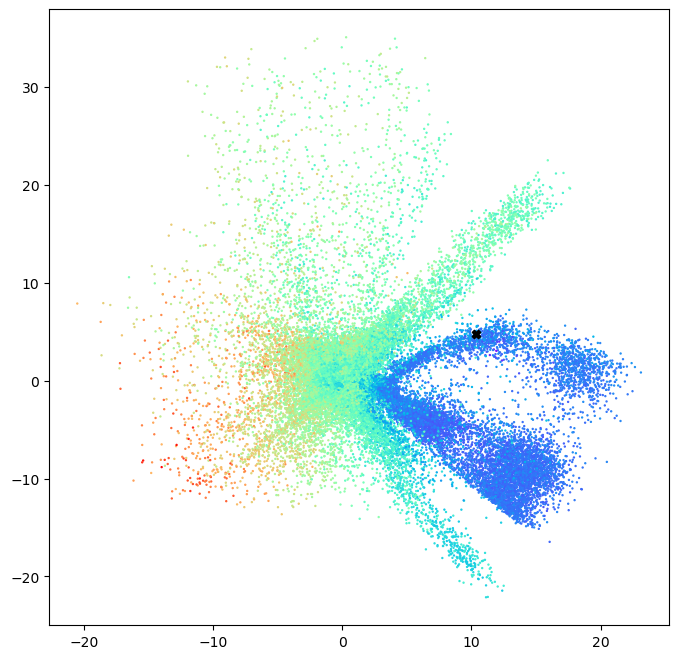

In [15]:
target = np.array([0, 0]).reshape(1, latent_dim)
bb_indices = traj.topology.select('backbone')
ca_indices = traj.topology.select('name CA')
emb, sample = plot_latent_space(latent_dim, encoder, ds_all, conf, tr, test, bb_indices, model=nn_model, exact=True)

In [16]:
rms_ref = md.load_pdb(conf)
rms_ref_bb  = rms_ref.atom_slice(bb_indices)
rms_ref_ca  = rms_ref.atom_slice(ca_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [17]:
'''
s = decoder.predict(sample)

coords_size = feat['coords'].shape[1]  # dimensione delle coordinate
angles_size = s.shape[1] - coords_size  # dimensione degli angoli

# Separa coordinate e angoli
s_coords = s[:, :coords_size]
s_angles = s[:, coords_size:]

# Inverti le trasformazioni separatamente
coords_orig = feat['scaler_coords'].inverse_transform(s_coords)
angles_orig = feat['scaler_angles'].inverse_transform(s_angles)

# Prendi solo le coordinate per la ricostruzione
coords_flat = coords_orig[0, :]                    
coords_p = coords_flat.reshape((n_p, 3))
mask_bb = np.isin(p_indices, bb_indices)
coords_bb = coords_p[mask_bb] 
coords_ca = coords_bb[1::4] 

new_traj = md.Trajectory(
    xyz=np.array([coords_bb]),     
    topology=rms_ref_bb.topology     
)

new_traj.save_pdb("./models/ae_reconstructed.pdb")
'''

'\ns = decoder.predict(sample)\n\ncoords_size = feat[\'coords\'].shape[1]  # dimensione delle coordinate\nangles_size = s.shape[1] - coords_size  # dimensione degli angoli\n\n# Separa coordinate e angoli\ns_coords = s[:, :coords_size]\ns_angles = s[:, coords_size:]\n\n# Inverti le trasformazioni separatamente\ncoords_orig = feat[\'scaler_coords\'].inverse_transform(s_coords)\nangles_orig = feat[\'scaler_angles\'].inverse_transform(s_angles)\n\n# Prendi solo le coordinate per la ricostruzione\ncoords_flat = coords_orig[0, :]                    \ncoords_p = coords_flat.reshape((n_p, 3))\nmask_bb = np.isin(p_indices, bb_indices)\ncoords_bb = coords_p[mask_bb] \ncoords_ca = coords_bb[1::4] \n\nnew_traj = md.Trajectory(\n    xyz=np.array([coords_bb]),     \n    topology=rms_ref_bb.topology     \n)\n\nnew_traj.save_pdb("./models/ae_reconstructed.pdb")\n'

In [18]:
'''
view = nv.show_file('./models/ae_reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view
'''

"\nview = nv.show_file('./models/ae_reconstructed.pdb')\nview.clear_representations()\nview.add_line() \n#view.add_cartoon()\nview.center()\nview\n"

In [19]:
print(f'distances feat: {nD}, angles feat: {nA}')

distances feat: 190, angles feat: 76


In [20]:
s = decoder.predict(sample)
orig = sample_x.numpy() 
recon = s[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


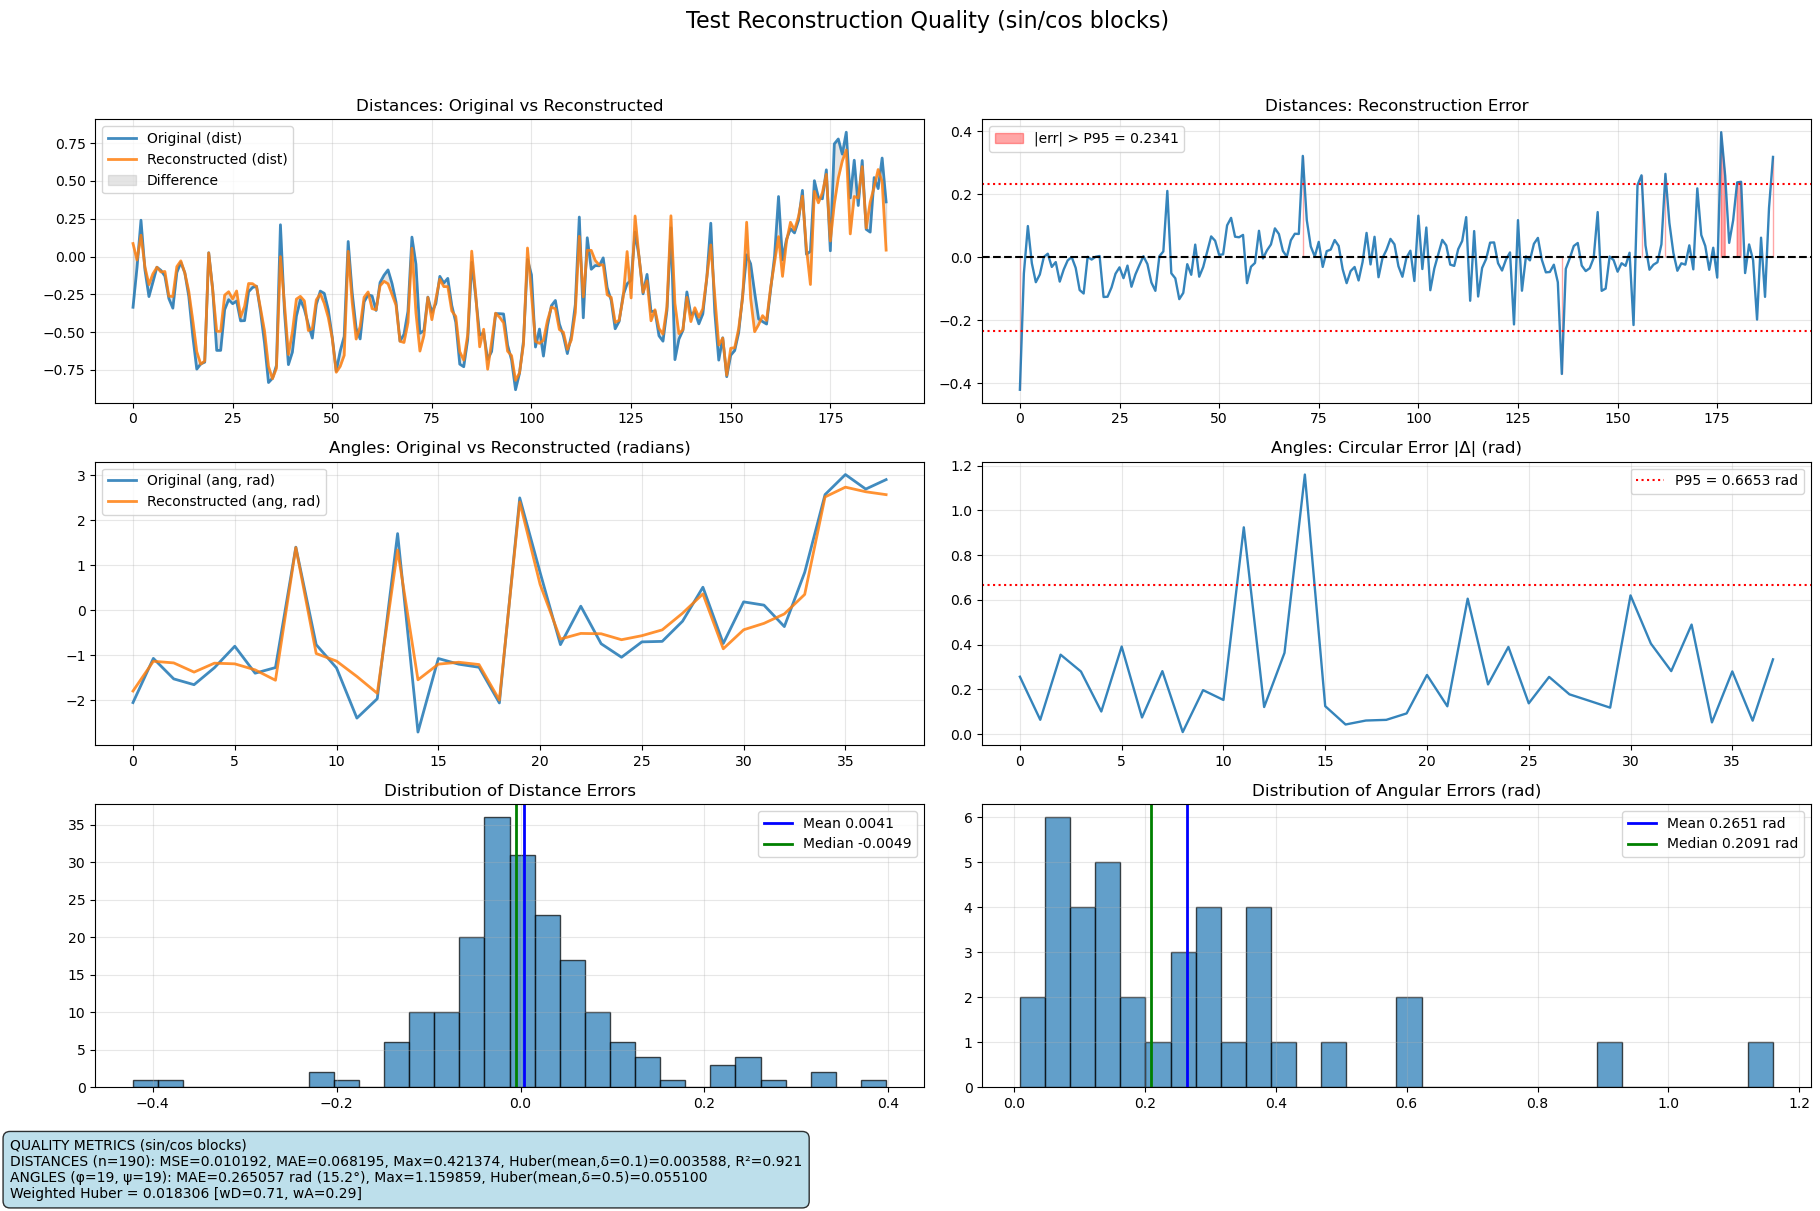

{'distances': {'mse': 0.010191831737756729, 'mae': 0.06819459795951843, 'max_abs_error': 0.42137426137924194, 'huber_mean': 0.0035879937931895256, 'r_squared': 0.9207766701196155, 'correlation': 0.9595710865379466}, 'angles': {'circ_mae_rad': 0.26505741477012634, 'circ_mae_deg': 15.18667119497677, 'max_circ_error_rad': 1.15985906124115, 'huber_mean_circ': 0.055099643766880035}, 'weights': {'distances': 0.7142857142857143, 'angles': 0.2857142857142857}, 'overall_weighted_huber': 0.01830560807138681}


In [21]:
n_phi = 0 if feat['raw_angles']['phi'] is None else feat['raw_angles']['phi'].shape[1]
n_psi = 0 if feat['raw_angles']['psi'] is None else feat['raw_angles']['psi'].shape[1]

fig, metrics = analyze_reconstruction_with_sincos_blocks(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    deltaD=0.1, deltaA=0.5,
    title_prefix="Test "
)

plt.show()
print(metrics)


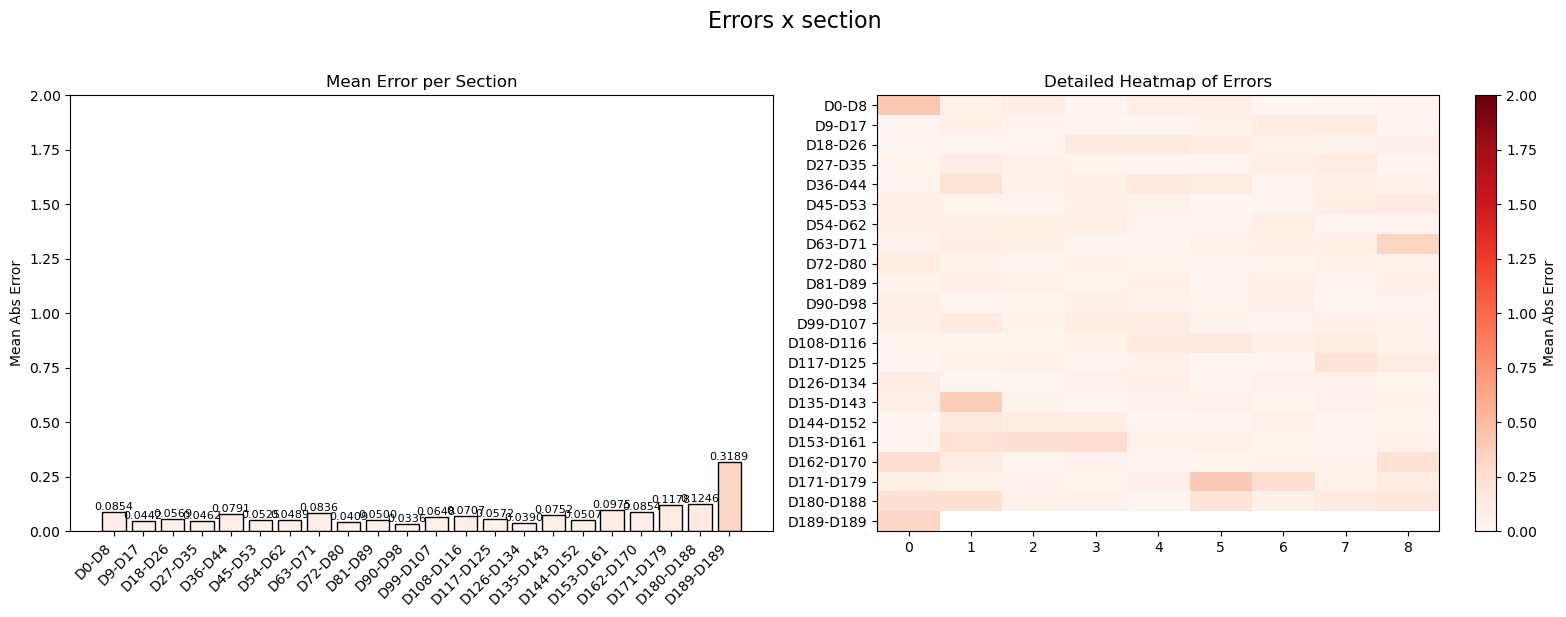

{'sections': [0.08535517007112503, 0.044170502573251724, 0.05689806491136551, 0.046150147914886475, 0.07911170274019241, 0.052521638572216034, 0.04889577627182007, 0.08358680456876755, 0.04088623449206352, 0.05002114921808243, 0.03362928703427315, 0.06476885825395584, 0.07071033120155334, 0.057184670120477676, 0.038959261029958725, 0.07524995505809784, 0.05070096626877785, 0.09754017740488052, 0.08544062077999115, 0.11784471571445465, 0.12459945678710938, 0.31894421577453613], 'labels': ['D0-D8', 'D9-D17', 'D18-D26', 'D27-D35', 'D36-D44', 'D45-D53', 'D54-D62', 'D63-D71', 'D72-D80', 'D81-D89', 'D90-D98', 'D99-D107', 'D108-D116', 'D117-D125', 'D126-D134', 'D135-D143', 'D144-D152', 'D153-D161', 'D162-D170', 'D171-D179', 'D180-D188', 'D189-D189'], 'kind': 'distance'}


In [22]:
fig, sec_stats = plot_section_errors(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    n_sections=20,     # divido in 5 blocchi
    kind="distance",  # oppure "angle"
    title="Errors x section"
)

plt.show()
print(sec_stats)

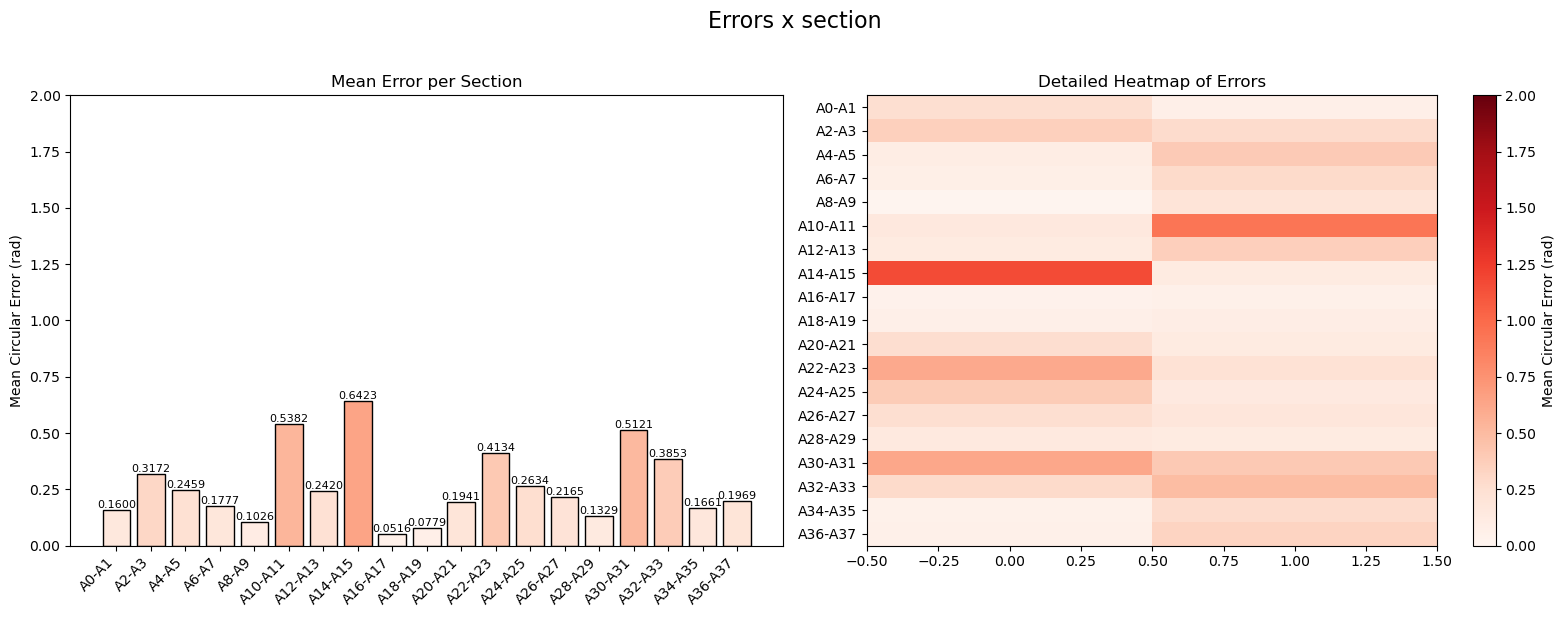

{'sections': [0.16004574298858643, 0.31715911626815796, 0.2458840310573578, 0.17768508195877075, 0.10260042548179626, 0.5382091403007507, 0.24196457862854004, 0.642321765422821, 0.05163979530334473, 0.07789945602416992, 0.1940918266773224, 0.41341596841812134, 0.26339057087898254, 0.2164946347475052, 0.1329312026500702, 0.5120610594749451, 0.3853421211242676, 0.16607356071472168, 0.19688093662261963], 'labels': ['A0-A1', 'A2-A3', 'A4-A5', 'A6-A7', 'A8-A9', 'A10-A11', 'A12-A13', 'A14-A15', 'A16-A17', 'A18-A19', 'A20-A21', 'A22-A23', 'A24-A25', 'A26-A27', 'A28-A29', 'A30-A31', 'A32-A33', 'A34-A35', 'A36-A37'], 'kind': 'angle'}


In [23]:
fig, sec_stats = plot_section_errors(
    orig, recon,
    nD=nD, n_phi=n_phi, n_psi=n_psi,
    n_sections=19,     # divido in 5 blocchi
    kind="angle",  
    title="Errors x section"
)

plt.show()
print(sec_stats)